# Imperfect tests

This model includes the sensitivity and specificity of the diagnostic test. 

\begin{equation}
  \begin{aligned}
    T_i &\sim \operatorname{Bernoulli}(p_i) \\
    p_i &= \gamma_s\theta_i + (1-\gamma_e)(1 - \theta_i),  \\
    g(\theta_i) &= g(\theta) + \boldsymbol{x}_i^T\beta,  \\
    \beta &\sim \operatorname{Normal}(\mu, \Sigma), \\ 
    \theta &\sim \operatorname{Beta}(a^p, b^p) \\
    \gamma_s &\sim \operatorname{Beta}(a^s, b^s), \\
    \gamma_e &\sim \operatorname{Beta}(a^e, b^e), \\    
  \end{aligned}  
\end{equation}

where $a^p, a^s, a^e, b^p, b^s, b^e \in \mathbb{R}_{++}$ are fixed hyperparameters.
This model does not include prior knowledge about the correlation between specificity and sensitivity. 


In [1]:
import numpy as np
import pystan as ps
from scipy.special import logit, expit

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle

import sys  
sys.path.insert(0, '../scripts/')

## Notebook settings

In [2]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Stan code 

Below we can see the code written in Stan. 

In [42]:
compiled = False
#compiled = True

if compiled: 
    sm = pickle.load(open('../models/primary_model/pickles/imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/primary_model/stan_codes/imperfect_test.stan')
    with open('../models/primary_model/pickles/imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)
        
sm_per = pickle.load(open('../models/primary_model/pickles/perfect_test.pkl', 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_75643a7c86173a662f3ad5c579a02275 NOW.


Below wee see the required data and transformed data. 

In [4]:
structure = sm.model_code.split('}')
print(structure[0] + '}' + structure[1]+'}') 

data {
    int<lower = 0> n_samples;
    int<lower = 0> n_predictors; 
  
    int Y[n_samples];
    matrix[n_samples, n_predictors] x;
    
    cov_matrix[n_predictors] Sigma; 
    vector[n_predictors] mu;
    real<lower = 0> alpha_p; 
    real<lower = 0> beta_p;
    real<lower = 0> alpha_s; 
    real<lower = 0> beta_s;
    real<lower = 0> alpha_e; 
    real<lower = 0> beta_e;
}
transformed data {
   matrix[n_predictors, n_predictors] sigma; 
   sigma = cholesky_decompose(Sigma);
}


And now the model and parameters

In [5]:
print(structure[2] + '}' + structure[3]+'}' + structure[4]+'}'+ structure[5]+'}') 


parameters {
    vector[n_predictors] normal_raw; 
    real<lower = 0, upper = 1> prev;
    real<lower = 0, upper = 1> sens;
    real<lower = 0, upper = 1> spec;
}
transformed parameters {
    vector[n_samples] p; 
    vector[n_predictors] effects; 
    effects = mu + sigma * normal_raw;
    p = (1 - spec) + (spec + sens - 1) * inv_logit(logit(prev) + x * effects);
}
model {
    normal_raw ~ std_normal();
    prev ~ beta(alpha_p, beta_p);
    sens ~ beta(alpha_s, beta_s);
    spec ~ beta(alpha_e, beta_e);
    Y ~ bernoulli(p);
}
generated quantities {
    vector[n_samples] theta;
    theta = inv_logit(logit(prev) + x * effects);
}


## Identifiability

In [6]:
n_samples    = 200
n_predictors = 5  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors), 
                           cov = np.eye(n_predictors),
                           size = n_samples)

# Normalization
x = (x - x.mean(axis=0))/x.std(axis = 0, ddof = 1)

Note that we generate $x$ in the same way as for perfect tests model tests. 

In [36]:
# Parameters we want to estimate
spec = 0.85
sens = 0.8

beta = np.array([0.1, 1.5, -1.0, 1.2, -0.3]).reshape(-1,1)
prevalence = 0.1

# Generated quantities

theta = expit(logit(prevalence) + x@beta)
p = sens*theta + (1 - spec)*(1 - theta)

T  = ro.binomial(n = 1, p = p)

# Hyperparameters to the estimation process
alpha_s = 1
beta_s  = 1
alpha_e = 1
beta_e  = 1
alpha_p = 1
beta_p  = 1
Sigma   = np.eye(5)
mu      = np.zeros(5)

# Data for the Stan code
data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "Y"            : T.flatten(),
    "X"            : x,
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,
}

T.mean()

0.295

How the numerical part of the problem enters the picture

In [38]:
%%time
fit_imperfect = sm.sampling(data=data, pars = ('prev', 'effects', 'spec', 'sens'), iter=8000)
summary = az.summary(fit_imperfect)

CPU times: user 345 ms, sys: 47.9 ms, total: 393 ms
Wall time: 7.06 s


Notice the very bad plots. 

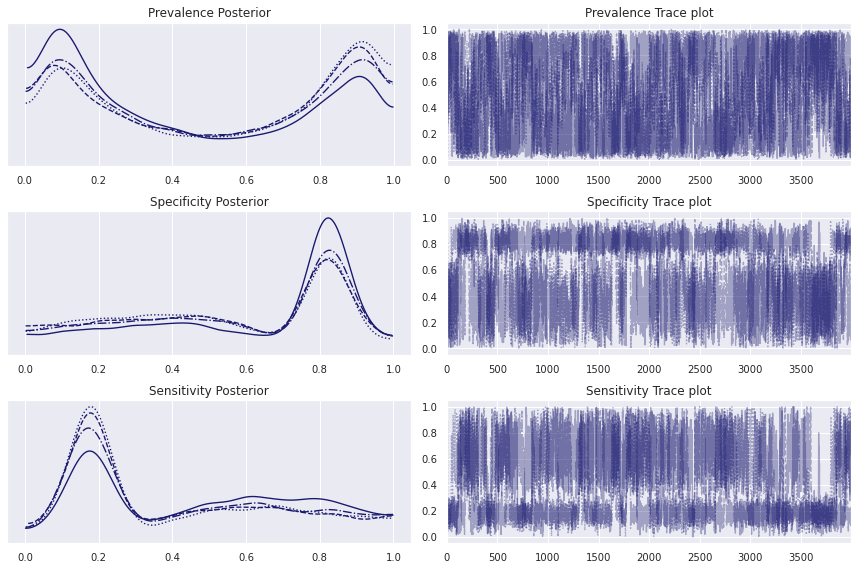

In [86]:
fig, ax = plt.subplots(3,2, figsize = (12, 8))
az.plot_trace(fit_imperfect, var_names=['prev', 'spec', 'sens'],
              chain_prop={'color': ['midnightblue'], 'linestyle': ['-', '--', '-.', ':']},
              axes = ax
             )
ax[0,0].set_title('Prevalence Posterior')
ax[1,0].set_title('Specificity Posterior')
ax[2,0].set_title('Sensitivity Posterior')
ax[0,1].set_title('Prevalence Trace plot')
ax[1,1].set_title('Specificity Trace plot')
ax[2,1].set_title('Sensitivity Trace plot')
fig.tight_layout(pad = 1)
plt.savefig('../images/posterior-trace-imperfect-tests-identifiability.pdf', bbox_inches='tight')
plt.show()

## Sanity check

In [45]:
def simulation(n_samples, prevalence, gamma_s, gamma_e, beta=[-0.1, 2.5, 1.4, -1.8, 0.3],
               n_pred_cont=3, n_pred_binary=2, seed=63289371):
    
    ro = np.random.RandomState(seed)
    
    n_predictors = n_pred_cont + n_pred_binary
    x = np.zeros((n_samples, n_predictors))
    x[:, :n_pred_cont] = ro.multivariate_normal(mean = np.zeros(n_pred_cont), 
                                                cov = np.eye(n_pred_cont),
                                                size = n_samples)
    x[:, :n_pred_cont] = 0.5 * (x[:, :n_pred_cont] - x[:, :n_pred_cont].mean(axis=0))/x[:, :n_pred_cont].std(axis = 0)
    x[:, n_pred_cont:] = ro.binomial(n = 1, p = [0.3, 0.7], size = (n_samples, n_pred_binary))
    
    theta = expit(logit(prevalence) + x@beta)
    T = ro.binomial(n = 1, p = 1-gamma_e + (gamma_e+gamma_s-1)*theta)
                      
    data = {
        "n_samples"    : n_samples,
        "n_predictors" : n_predictors,
        "Y"            : T.flatten(),
        "X"            : x,
    } 
    
    return data

In [46]:
data = simulation(n_samples=200, prevalence=0.1, gamma_s=0.9, gamma_e=0.8, seed=63289371)
# Prior specification
data.update({    
    "Sigma"        : 4*np.eye(5),
    "mu"           : np.zeros(5),
    "alpha_p"      : 1,
    "beta_p"       : 1,
    "alpha_s"      : 9,
    "beta_s"       : 1,
    "alpha_e"      : 8,
    "beta_e"       : 2,
})

In [47]:
%%time
fit_imperfect = sm.sampling(data=data, iter=4000, pars=('prev', 'sens', 'spec', 'effects'))
summary = az.summary(fit_imperfect)

CPU times: user 176 ms, sys: 40.1 ms, total: 216 ms
Wall time: 2.8 s


In [48]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.095,0.071,0.002,0.216,0.001,0.001,3753.0,4625.0,1.0
sens,0.879,0.103,0.687,1.000,0.001,0.001,5494.0,3833.0,1.0
spec,0.774,0.052,0.680,0.874,0.001,0.001,3337.0,2156.0,1.0
effects[0],-1.068,0.939,-2.828,0.764,0.012,0.010,6122.0,4705.0,1.0
effects[1],2.796,1.191,0.709,5.076,0.018,0.013,4409.0,4937.0,1.0
effects[2],0.645,0.855,-0.923,2.272,0.011,0.009,6700.0,4926.0,1.0
effects[3],-1.496,1.149,-3.756,0.504,0.014,0.012,6983.0,4477.0,1.0
effects[4],0.533,0.981,-1.269,2.434,0.013,0.011,5916.0,4164.0,1.0


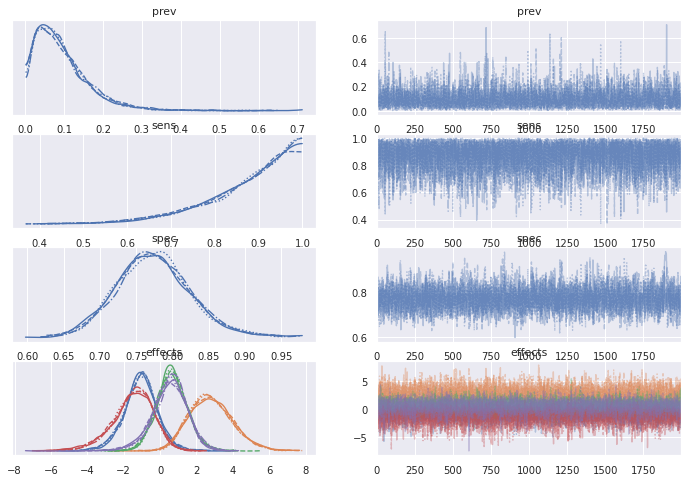

In [49]:
az.plot_trace(fit_imperfect)
plt.show()

In [50]:
fit_perfect = sm_per.sampling(data=data, iter=4000, pars=('prev', 'effects'))
summary = az.summary(fit_perfect)

In [51]:
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prev,0.251,0.053,0.154,0.351,0.001,0.001,4970.0,4729.0,1.0
effects[0],-0.421,0.311,-1.023,0.141,0.003,0.003,8192.0,6523.0,1.0
effects[1],0.763,0.316,0.172,1.340,0.004,0.003,8160.0,5305.0,1.0
effects[2],0.056,0.311,-0.535,0.624,0.003,0.003,8399.0,6002.0,1.0
effects[3],-0.351,0.331,-0.954,0.297,0.004,0.003,7271.0,6018.0,1.0
effects[4],0.739,0.338,0.123,1.391,0.005,0.004,5038.0,5097.0,1.0


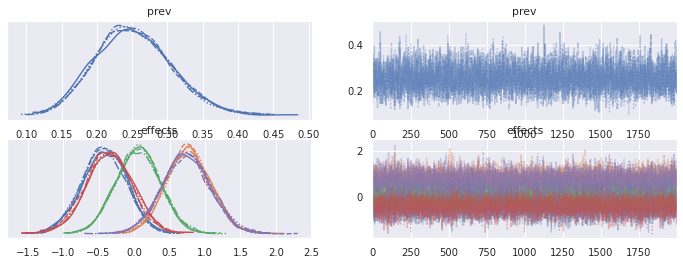

In [52]:
az.plot_trace(fit_perfect)
plt.show()